In [1]:
import sys
import pandas as pd
import random
import math
#import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import special
from numpy import genfromtxt
import operator

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (NVIDIA A100-PCIE-40GB) of compute capability 8.0 with 42.4Gb total memory.



# compound poisson gaussian

In [3]:

#Initialization for multivariate gaussian parameters
#parameter alpha is the location parameter, and beta is the covariance matrix/std parameter
#the covariance parameter is estimated by the unbiased estimator

def initialization_mvg(theta, data, corr):
    
  if corr == True:
      #theta is a numerical value
      #data should be the count matrix in tensor form
      theta = torch.tensor(theta, device = dev)
      alpha = torch.mean(data, dim=0)
      beta = torch.cov(torch.transpose(data,0,1))



      theta = theta.requires_grad_()
      alpha = alpha.requires_grad_()
      beta = beta.requires_grad_()

  else:
      #theta is a numerical value
      #data should be the count matrix in tensor form
      theta = torch.tensor(theta, device = dev)
      alpha = torch.mean(data, dim=0)
      var = torch.var(data, dim=0)
      beta = torch.sqrt(var)


      theta = theta.requires_grad_()
      alpha = alpha.requires_grad_()
      beta = beta.requires_grad_()
  

  
  return theta, alpha, beta



#log likelihood with logsumexp
def loglik_mvg(N, theta, alpha, beta, decay, data, corr):

  if corr == True:
    
      #N is the user estimated maximum number of cells in a droplet
      #theta, alpha, and beta are outputs from initialization function
      #data should be the count matrix in tensor form
      poisson = torch.distributions.Poisson(theta)
      list_k = torch.zeros(N,data.shape[0])
      for k in range(N):
        gaussian = torch.distributions.MultivariateNormal(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), torch.tensor(k+1, device = dev)*beta)
        list_k[k] = gaussian.log_prob(data)+poisson.log_prob(torch.tensor([k], device = dev))

      sum_k = torch.logsumexp(list_k,0)
      l = torch.sum(sum_k, dtype = torch.float64)

    
  else: 
      #N is the user estimated maximum number of cells in a droplet
      #theta, alpha, and beta are outputs from initialization function
      #data should be the count matrix in tensor form
      poisson = torch.distributions.Poisson(theta)
      list_k = torch.zeros(N, data.shape[0], data.shape[1])
      for k in range(N):
        gaussian = torch.distributions.Normal(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), torch.tensor(k+1, device = dev)*beta)
        list_k[k] = gaussian.log_prob(data)+poisson.log_prob(torch.tensor([k], device = dev))

      sum_k = torch.logsumexp(list_k, 0)
      l = torch.sum(sum_k, dtype = torch.float64)


  return l

def MLE_mvg(data, N=3, p=0.75, lr=0.02, tolerance = 15, corr = False):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization_mvg(theta, data, corr)
    alpha0 = 0.5*torch.mean(alpha).to('cpu').detach().item()

    parameters = [theta, alpha, beta, decay]

    # Defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(parameters, lr=lr) # not working
    optimizer = optim.Adam(parameters, lr=lr, eps = 1e-6, weight_decay=0.1)
    #optimizer = optim.Rprop(parameters, lr=lr)
    #NLL_0 = -loglik_mvg(N, theta, alpha, beta, decay, x)
    l = []
    singlet_rate = []

    
    for i in range(10000):
        NLL = -loglik_mvg(N, theta, alpha, beta, decay, x, corr)
        if i % 200 == 0:
            if i%1000 == 0:
                pass
                #print("neg loglik  =", i, NLL.data, theta.data, decay.data)
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1
        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.01, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = 0)
        beta.data.clamp_(min = 0)
        


    return theta, alpha, beta, decay, l, singlet_rate


In [4]:


def log_joint_one_k(data, theta, alpha, beta, decay, k0, corr):
    
  if corr == True:
      #k0 starts from 0, same interpretation as the k0 in the derivation
      alpha = alpha.to('cpu').detach().numpy()
      beta = beta.to('cpu').detach().numpy()
      data = data.to('cpu').numpy()
      theta = theta.to('cpu').detach().numpy()
      decay = decay.to('cpu').detach().numpy()

      alpha = alpha*(1+k0/(1+np.exp(-decay)))

      log_conditional = np.log(multivariate_normal.pdf(data, mean=alpha, cov=beta)+1e-320) 
      log_joint = log_conditional + np.log(poisson.pmf(k0, theta))

    
  else:
      #k0 starts from 0, same interpretation as the k0 in the derivation
      alpha = alpha.to('cpu').detach().numpy()
      beta = beta.to('cpu').detach().numpy()
      data = data.to('cpu').numpy()
      theta = theta.to('cpu').detach().numpy()
      decay = decay.to('cpu').detach().numpy()

      alpha = alpha*(1+k0/(1+np.exp(-decay)))

      log_conditional = np.log(norm.pdf(data, loc=alpha, scale=beta)+1e-320) #add a small value to avoid log(0)
      sum_gene = np.sum(log_conditional, axis = 1)
      log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
      var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0(data, theta, alpha, beta, decay, k0, k=3, corr = False):
  log_joint_k0 = log_joint_one_k(data, theta, alpha, beta, decay, k0, corr)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k(data, theta, alpha, beta, decay, i, corr)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)


  return prob

def reliability(data, theta, alpha, beta, decay, k=3,corr = False):
    
    if corr == True:
        beta = torch.diagonal(beta, 0)
        beta = torch.sqrt(beta)
    
        prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k, corr = True)
        prob_doublet = 1-prob_singlet
        pred = np.where(prob_doublet > 0.5, True, False)
        
    else:
        prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k)
        prob_doublet = 1-prob_singlet
        pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = small_stable.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(norm.pdf(data, loc=alpha_k, scale=beta)+1e-320)

    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature

    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def adt_fit_goodness(data, alpha, beta, theta, decay, k=3, corr=False):
    
    if corr == True:
        beta = torch.diagonal(beta, 0)
        beta = torch.sqrt(beta)
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0]
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(norm.cdf(grid, loc=alpha_k, scale=beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    return mean_ks

def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    precision = np.sum(dichotomized[label==1]==1)/np.sum(dichotomized==1)
    prop = np.sum(dichotomized==1)/label.shape[0]
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    print("Predicted doublet proportion:",prop)
    print("Precision:", precision)
    print("f1 score:", f1)
    
    return sensitivity, specificity

## PB-1 ADT

In [5]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220215_1/
stable = pd.read_csv("./ADT_stable50_cts.csv")
small_stable = stable.iloc[:, 1:17] #16 stable features


/ix1/wchen/Haoran/CPDD/ADT/20220215_1


In [6]:
small_stable = torch.tensor(small_stable.values, device = dev) 
small_stable = small_stable.double() 
small_stable = small_stable + torch.tensor([0.0001], device = dev)

In [7]:
theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ihome/crc/install/cuda-11.3/pytorch/1.11.0_gpu/python3.8/lib/python3.8/site-packages/torch/distributions/poisson.py:63: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /ihome/wchen/hah112/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  return value.xlogy(rate) - rate - (value + 1).lgamma()


In [8]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17749397007447112

In [9]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)

0.750225550017281


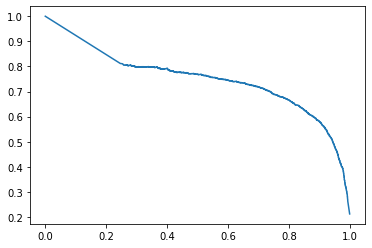

In [10]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [11]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.25097380279538684
Precision: 0.6710286062081559
f1 score: 0.726643598615917


In [12]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220215_1_adt.csv',index=False)

In [13]:
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_1_adt.csv',index=False)

In [14]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220215_1_3.0.csv',index=False)

## PB-1 RNA+ADT

In [15]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_1/doublet_20220215_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/doublet_20220215_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_1/reliability_20220215_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/reliability_20220215_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()


In [16]:
reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8146110937615043


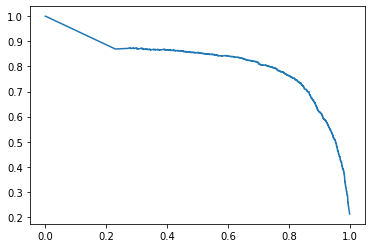

In [17]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [18]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2749560834033453
Precision: 0.675
f1 score: 0.76139746200846


## PB-2 ADT

In [19]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220215_2/
stable = pd.read_csv("./ADT_stable50_cts.csv")
small_stable = stable.iloc[:, 1:17] #16 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220215_2


In [20]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.16193015462577284

0.7362341146683002


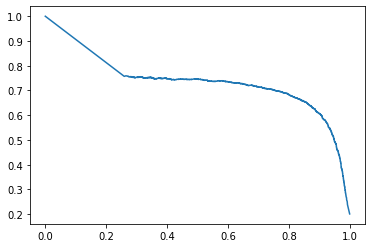

In [21]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [22]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.24255788313120177
Precision: 0.6747159090909091
f1 score: 0.7379213919527731


In [23]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)

doublet_prediction.to_csv('doublet_20220215_2_adt.csv',index=False)

In [24]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_2_adt.csv',index=False)

In [25]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220215_2_3.0.csv',index=False)

## PB-2 RNA+ADT

In [26]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_2/doublet_20220215_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/doublet_20220215_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_2/reliability_20220215_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/reliability_20220215_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.795866988396913


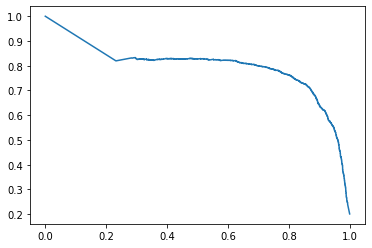

In [27]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [28]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2861769570011025
Precision: 0.6342403082109318
f1 score: 0.745120226308345


## PB-3 ADT

In [29]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220218_1/
stable = pd.read_csv("./ADT_stable50_cts.csv")
small_stable = stable.iloc[:, 1:17] #16 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220218_1


In [30]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1879028690185906

0.7356642273385636


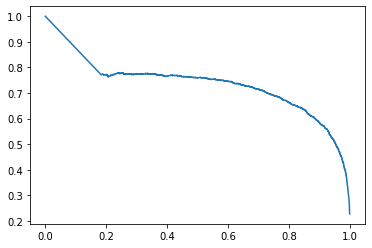

In [31]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [32]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.20611047413502395
Precision: 0.7277486910994765
f1 score: 0.6916498211786659


In [33]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_1_adt.csv',index=False)

In [34]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_1_adt.csv',index=False)

In [35]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220218_1_3.0.csv',index=False)

## PB-3 RNA+ADT

In [36]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_1/doublet_20220218_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/doublet_20220218_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_1/reliability_20220218_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/reliability_20220218_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7989098360117622


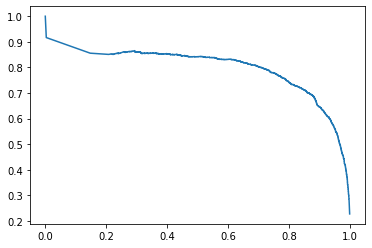

In [37]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [38]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2760504485061037
Precision: 0.7068165160029318
f1 score: 0.7747723620782002


## PB-4 ADT

In [39]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220218_2/
stable = pd.read_csv("./ADT_stable50_cts.csv")
small_stable = stable.iloc[:, 1:17] #300 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220218_2


In [40]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.2071676138066635

0.7058803315104962


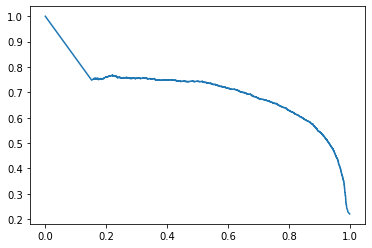

In [41]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [42]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.19270864008481065
Precision: 0.71179706601467
f1 score: 0.6639110604332953


In [43]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_2_adt.csv',index=False)

In [44]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_2_adt.csv',index=False)

In [45]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220218_2_3.0.csv',index=False)

## PB-4 RNA+ADT

In [46]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_2/doublet_20220218_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/doublet_20220218_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_2/reliability_20220218_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/reliability_20220218_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7548370838583119


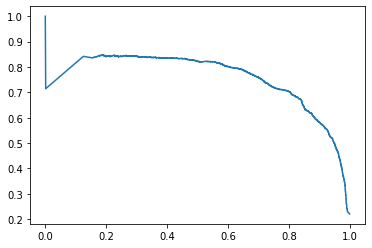

In [47]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [48]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.25932033688674244
Precision: 0.6897569838746309
f1 score: 0.7455505093899595


## Ileum-1 ADT

In [49]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230124_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230124_1


In [50]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1643149606878026

0.7073628894042571


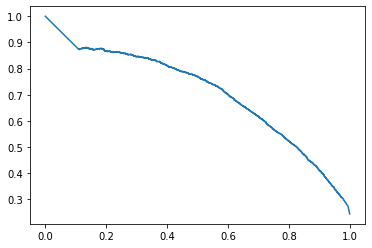

In [51]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [52]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.20585616258970196
Precision: 0.7055979643765903
f1 score: 0.6458600209619192


In [53]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_1_adt.csv',index=False)

In [54]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_1_adt.csv',index=False)

In [55]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20230124_1_3.0.csv',index=False)

## Ileum-1 RNA+ADT

In [56]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_1/doublet_20230124_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/doublet_20230124_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_1/reliability_20230124_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/reliability_20230124_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7281464295529174


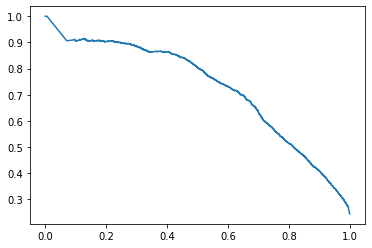

In [57]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [58]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.21622754177361062
Precision: 0.7126937984496124
f1 score: 0.669778030734206


## Ileum-2 ADT

In [59]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230124_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
#small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230124_2


In [60]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17030380256958996

0.7000026116924256


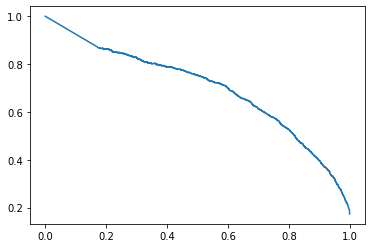

In [61]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [62]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2339631309940849
Precision: 0.5660284732449681
f1 score: 0.6497604959143422


In [63]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_2_adt.csv',index=False)

In [64]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_2_adt.csv',index=False)

## Ileum-2 RNA+ADT

In [65]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_2/doublet_20230124_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/doublet_20230124_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_2/reliability_20230124_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/reliability_20230124_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6966583427719587


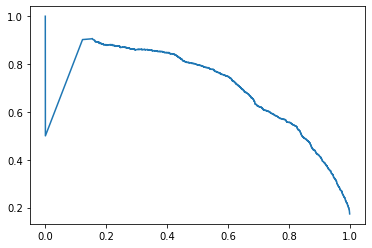

In [66]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [67]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2466547981393212
Precision: 0.5585564610011642
f1 score: 0.6555540374368084


## Ileum-3 ADT

In [68]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230126_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230126_1


In [69]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.16635978242630536

0.6440151524783821


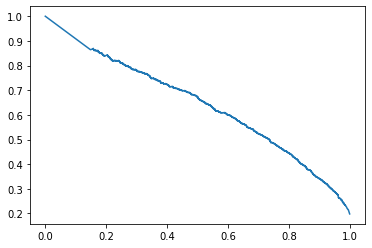

In [70]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [71]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23113623018203172
Precision: 0.561765639885678
f1 score: 0.6047863247863248


In [72]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_1_adt.csv',index=False)

In [73]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_1_adt.csv',index=False)

## Ileum-3 RNA+ADT

In [74]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_1/doublet_20230126_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/doublet_20230126_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_1/reliability_20230126_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/reliability_20230126_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)


0.6323615310538565


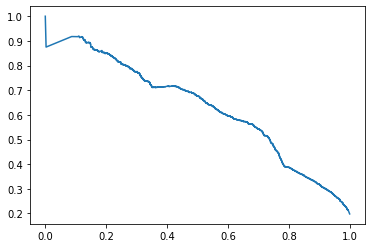

In [75]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [76]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.24185261303581915
Precision: 0.5596358118361153
f1 score: 0.6150767178118746


## Ileum-4 ADT

In [77]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230126_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230126_2


In [78]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.18765335251372328

0.6537714419107716


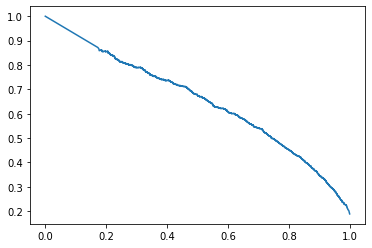

In [79]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [80]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23421617752326412
Precision: 0.5504278728606357
f1 score: 0.609888249238063


In [81]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_2_adt.csv',index=False)

In [82]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_2_adt.csv',index=False)

## Ileum-4 RNA+ADT

In [83]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_2/doublet_20230126_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/doublet_20230126_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_2/reliability_20230126_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/reliability_20230126_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6437979272638845


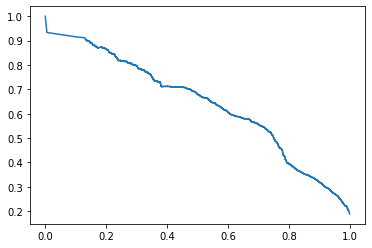

In [84]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [85]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2546170365068003
Precision: 0.5366882204104583
f1 score: 0.6167016637053787


## Ileum-5 ADT

In [86]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230203_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
#small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230203_1


In [87]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1652148229117705

0.6330489960109048


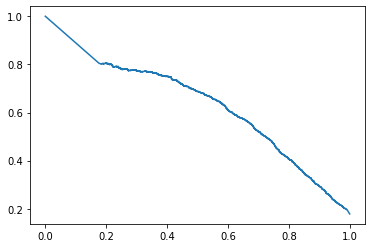

In [88]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [89]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23765106659096438
Precision: 0.5238907849829352
f1 score: 0.5982073265783321


In [90]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_1_adt.csv',index=False)

In [91]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_1_adt.csv',index=False)

## Ileum-5 RNA+ADT

In [92]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_1/doublet_20230203_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/doublet_20230203_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_1/reliability_20230203_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/reliability_20230203_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6875483346057926


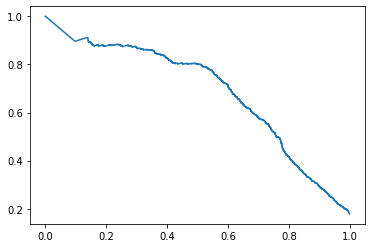

In [93]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [94]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.24754643523400113
Precision: 0.5344036697247706
f1 score: 0.6208602969166349


## Ileum-6 ADT

In [95]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230203_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230203_2


In [96]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17386879095677144

0.6065795553625702


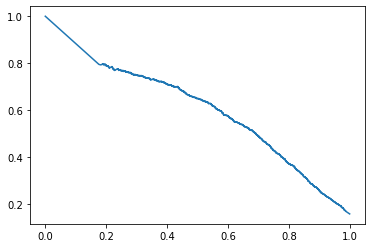

In [97]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [98]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2283720175296218
Precision: 0.4896943852167733
f1 score: 0.5766896840343169


In [99]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_2_adt.csv',index=False)

In [100]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_2_adt.csv',index=False)

## Ileum-6 RNA+ADT

In [101]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_2/doublet_20230203_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/doublet_20230203_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_2/reliability_20230203_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/reliability_20230203_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6582241717485177


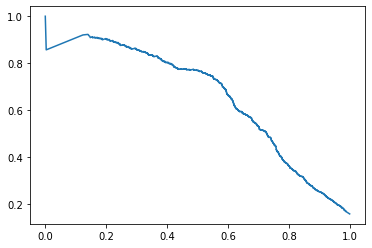

In [102]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [103]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.26643402045122544
Precision: 0.4514163874505026
f1 score: 0.5647865853658537


## Ileum-7 ADT

In [104]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20230206_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20230206_2


In [105]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17950943122214633

0.6982559792436565


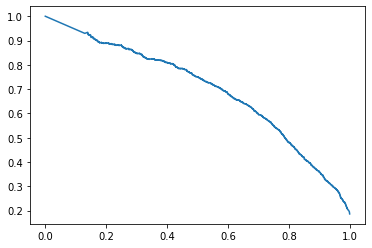

In [106]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [107]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.21259429321088882
Precision: 0.6075285405738969
f1 score: 0.6473779385171791


In [108]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230206_2_adt.csv',index=False)

In [109]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230206_2_adt.csv',index=False)

## Ileum-7 RNA+ADT

In [110]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230206_2/doublet_20230206_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/doublet_20230206_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230206_2/reliability_20230206_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/reliability_20230206_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230206_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7043572404041847


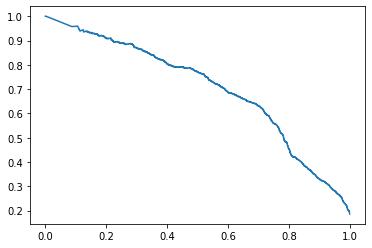

In [111]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [112]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.25792062971466057
Precision: 0.5503560528992879
f1 score: 0.6389134927664601


## PB-5 ADT

In [113]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220429_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220429_1


In [114]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.15049882530262132

0.7487165305320216


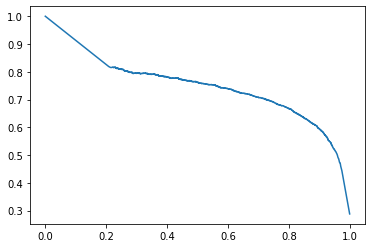

In [115]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [116]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23672358327146745
Precision: 0.7374033033660883
f1 score: 0.6650952291155949


In [117]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_1_adt.csv',index=False)

In [118]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_1_adt.csv',index=False)

## PB-5 RNA+ADT

In [119]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_1/doublet_20220429_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/doublet_20220429_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_1/reliability_20220429_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/reliability_20220429_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7824952510893416


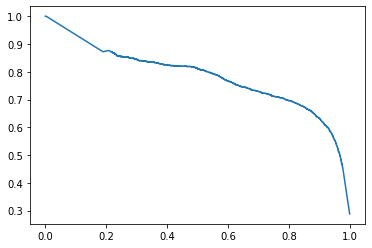

In [120]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [121]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.25454095520910663
Precision: 0.7443126579817227
f1 score: 0.698157942732081


## PB-6 ADT

In [122]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220429_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220429_2


In [123]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1774124321363691

0.7196410010806743


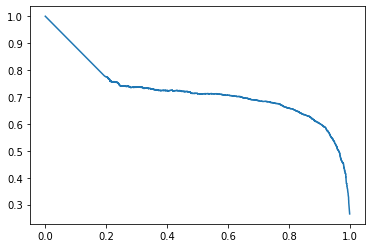

In [124]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [125]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2488456995597552
Precision: 0.6960086299892125
f1 score: 0.673556738699238


In [126]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_2_adt.csv',index=False)

In [127]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_2_adt.csv',index=False)

## PB-6 RNA+ADT

In [128]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_2/doublet_20220429_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/doublet_20220429_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_2/reliability_20220429_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/reliability_20220429_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7561877987815662


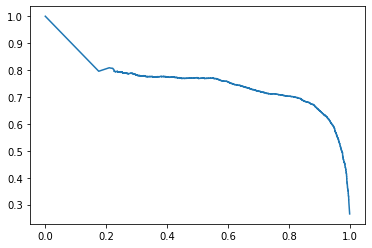

In [129]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [130]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.290024696660582
Precision: 0.7078859681599408
f1 score: 0.7392228880726851


## PB-7 ADT

In [131]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220429_3/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220429_3


In [132]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.17802107006953802

0.7835523861750489


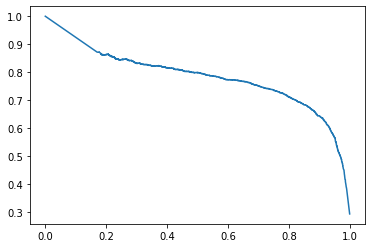

In [133]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [134]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.2275201710897249
Precision: 0.7735526596881008
f1 score: 0.6744900810282201


In [135]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_3_adt.csv',index=False)

In [136]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_3_adt.csv',index=False)

## PB-7 RNA+ADT

In [137]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_3/doublet_20220429_3_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/doublet_20220429_3_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_3/reliability_20220429_3_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/reliability_20220429_3_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_3/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7997720621794453


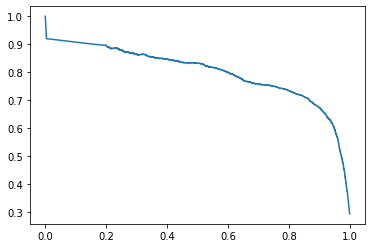

In [138]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)
#prob_doublet,  = prob_doublet[1201:3201]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [139]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27277145912316514
Precision: 0.75784034212402
f1 score: 0.7290023997257457


## PB-8 ADT

In [140]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220524_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220524_1


In [141]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.19111395019756786

0.8235757206142889


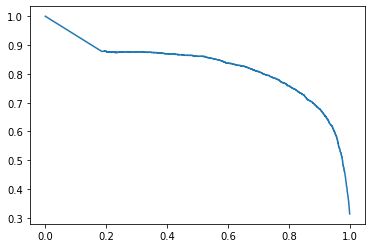

In [142]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [143]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.21959743419597433
Precision: 0.8406526994359388
f1 score: 0.6920398009950249


In [144]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_1_adt.csv',index=False)

In [145]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_1_adt.csv',index=False)

## PB-8 RNA+ADT

In [146]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_1/doublet_20220524_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/doublet_20220524_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_1/reliability_20220524_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/reliability_20220524_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7820904875092041


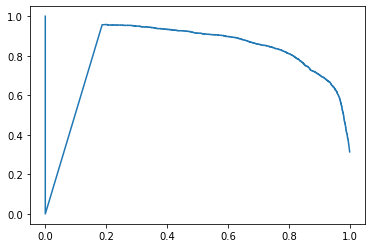

In [147]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [148]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.3574872815748728
Precision: 0.7504021779482737
f1 score: 0.7991039072280425


## PB-9 ADT

In [149]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20220524_2/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20220524_2


In [150]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1801590266435273

0.8216670283005032


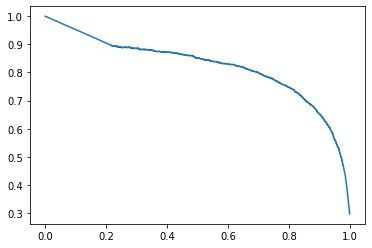

In [151]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [152]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.23261217534982187
Precision: 0.8204217536071032
f1 score: 0.7206785609827434


In [153]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_2_adt.csv',index=False)

In [154]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_2_adt.csv',index=False)

## PB-9 RNA+ADT

In [155]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_2/doublet_20220524_2_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/doublet_20220524_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_2/reliability_20220524_2_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/reliability_20220524_2_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_2/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8754699031468971


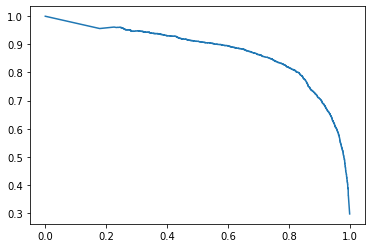

In [156]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [157]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.32178447875251714
Precision: 0.7816110397946084
f1 score: 0.8129172229639521


## PB-10 ADT

In [158]:
%cd /ix1/wchen/Haoran/CPDD/ADT/20210831_1/
stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
small_stable = stable[:,0:16] #16 stable features

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()


theta,alpha,beta,decay, loss_075,p_075 = MLE_mvg(small_stable)

/ix1/wchen/Haoran/CPDD/ADT/20210831_1


In [159]:
weight = adt_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.1660582203655634

0.7265212135887874


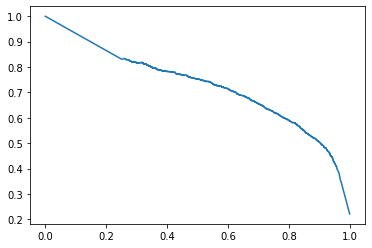

In [160]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [161]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2403480465598709
Precision: 0.652361543994246
f1 score: 0.6785536159600997


In [162]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20210831_1_adt.csv',index=False)

In [163]:
reliability_table = reliability(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20210831_1_adt.csv',index=False)

## PB-10 RNA+ADT

In [164]:
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20210831_1/doublet_20210831_1_adt.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/doublet_20210831_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20210831_1/reliability_20210831_1_adt.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/reliability_20210831_1_rna.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20210831_1/doublet.csv")

adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((adt_reliability, rna_reliability))
reliability_joint[1,:] = reliability_joint[1,:]
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6424808331539906


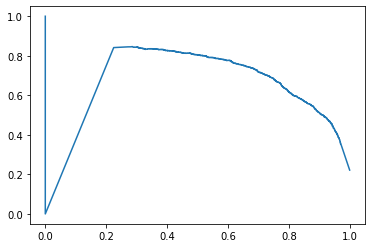

In [165]:
combined_prediction = reliability_joint[0,:]*adt_doublet + reliability_joint[1,:]*rna_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [166]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.28310475970957705
Precision: 0.6238550783635254
f1 score: 0.6996119607395572
